In [1]:
%matplotlib notebook

In [2]:
import pylab as pl
import matplotlib as mpl
import numpy as np
#import netCDF4 as nc
#import netcdftime as nt

import matplotlib.pyplot as plt
from ftplib import FTP
import os, sys, array, zlib  #, Image
import glob
import wradlib
import h5py
import datetime
import scipy
from scipy import ndimage
from scipy import signal, fftpack
from scipy.interpolate import UnivariateSpline

In [38]:
import os
#import glob
from glob import glob
from collections import namedtuple

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import wradlib
import wradlib.adjust as adjust
import wradlib.verify as verify
import wradlib.util as util

import numpy as np

import datetime
#from datetime import timedelta
import time

import netCDF4 as nc
from netCDF4 import Dataset
from netCDF4 import num2date, date2num

# For progress bars
import ipywidgets
from IPython.core.display import display

# To supress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import Load, Sanity, Show, Save

# Georeferencing Rainscanner data

In [5]:
radar_location = (11.028760, 47.728040, 955) # (lon, lat, alt) in decimal degree and meters
elevation = 3.0 # in degree
azimuths_RS = np.arange(0,360,2) # in degrees
ranges_RS_max = np.arange(0, 50000., 100.) # in meters

range_max = 500  # select the data range (max=500)
ranges_RS = ranges_RS_max[:range_max]

polargrid = np.meshgrid(ranges_RS, azimuths_RS)
lon_RS, lat_RS, alt_RS = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1], elevation, radar_location)

# Raw data .azi directory

Adjust this to point to your ISILONA network path!

In [6]:
#raw_data_root_path = 'C:\\Users\\bialas-j\\Documents\\standard-gap.azi\\'
azi_data_root_path = 'E:\\IFU\\standard-gap.azi\\'

# Read Rainscanner data (.azi) of the month

This may take some time


In [7]:
year = '2017'
month = '01'
fn_list = Load.get_monthly_data(azi_data_root_path, year, month)
#data_list = Load.read_fn_list(fn_list[:41], range_max)
#data_list = Load.read_azi_list(fn_list[:41], range_max)

E:\IFU\standard-gap.azi\2017\2017-01


In [8]:
print len(fn_list)
print fn_list[:1]

#print data_list[0].date
#print data_list[1].dBZ

4831
['E:\\IFU\\standard-gap.azi\\2017\\2017-01\\2017-01-02\\2017010210150000dBuZ.azi']


In [9]:
data_list, XML_list, time_list = Load.read_azi_list(fn_list[100:109], range_max)

In [10]:
print len(data_list)
#print data_list[:1]
#print len(XML_list)
print XML_list[:1]
print time_list[:1]

9
[{'undetected': -31.5, 'astart': 0.0, 'date': u'2017-01-02', 'beamwidth': 1.0, 'wavelength': 0.05, 'rpm': 72.0, 'highprf': 833.0, 'altitude': 955.0, 'lon': 11.02876, 'system': 'GAP', 'source': 'WMO:0,PLC:GAP', 'min_dynz': -31.5, 'bins_XML': 500, 'product': 'SCAN', 'elevation': 99.99, 'endtime_round': u'18:35:00', 'rscale': 100.0, 'object': 'SCAN', 'rstart': 0.0, 'gain': 1.0, 'offset': 0.0, 'lat': 47.72804, 'endtime': u'18:34:56', 'software': 'RAINBOW', 'enddate': u'2017-01-02', 'max_dynz': 95.5, 'time': u'18:32:55', 'rays_XML': 180, 'nodata': -99.99, 'quantity': 'TH'}]
[u'2017-01-02 18:35:00']


In [11]:
#break

# Load Reference scan for azimuth correction

In [12]:
io_path_Ref = 'C:\\Users\\bialas-j\\Documents\\standard-gap.azi\\Azimuts\\Reference\\Ref_mean\\Ref_simple_mean60.npz'
Ref_data = []
Ref_data = Load.Reference(io_path_Ref)

show Reference

In [35]:
max_r = 500
r = np.arange(0,50000, 100)[:max_r]/1000.
az = np.arange(0, 360,2)

data = []
data = Ref_data[:,:max_r]
##Zugspitze only
#data = Ref_data[:,:max_r]*np.nan
#data[172/2:192/2,330:370] = Ref_data[172/2:192/2,330:370]

#Time_RS = num2date(time_RS[i],units='hours since 2000-01-01 00:50:00.0',calendar='standard')
#time_file_s=int(float(file_list[0][:12]))
#time_file_e=int(float(file_list[n][:12]))
#print(time_file_s)
#time_start = datetime.datetime.strptime(str(time_file_s),'%Y%m%d%H%M')
#time_end = datetime.datetime.strptime(str(time_file_e),'%Y%m%d%H%M')
#print(time_start)
#print(time_end)

#title = 'Ref_dBZ_mean'+ '\n'+str(time_start)+'  to  '+str(time_end)+'\ncumul.= '+str(n)+' scans'
title = '\n'+'Ref_dBZ_mean'+ '\n'
units = 'dBZ'


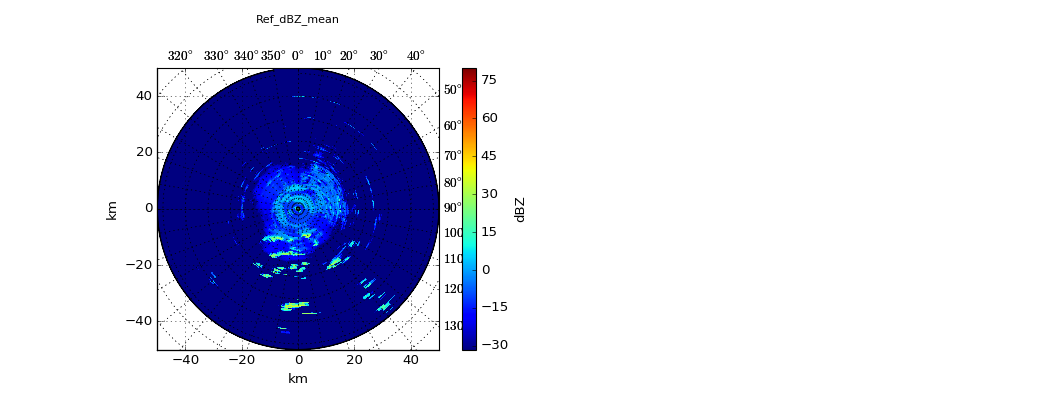

In [36]:
fig = plt.figure(figsize=(13,5))
subplot = 121

#fraction=0.1
#shrink=1
#pad=0.09
#fontsize=12

Show.polar_plot(data, r, az, title, units, subplot)

In [15]:
#break

# Sanity checks

threshold for empty scans

In [16]:
## threshold for empty scan (sum of 4 slices)
thr_empty = 90      ##dBZ

correct number of azimuths

In [17]:
ray_number = 180

In [39]:
data_list_clean = []
XML_list_clean = []
time_list_clean = []
a = []
b = []
pbar = ipywidgets.FloatProgress(min=0, max=(len(time_list)-1))
display(pbar)
for i in np.arange(0, len(time_list)):
    pbar.value = i
    data = data_list[i]
    XML_data = XML_list[i]
    time = time_list[i]
    
    a, b, data_list_clean, XML_list_clean, time_list_clean = Sanity.clean_up(data, XML_data, time, thr_empty, ray_number, 
                                                            data_list_clean, XML_list_clean, time_list_clean, a, b)

In [19]:
#print a, b
#print time_list_clean

Reference becons to alligne the azimuth

In [20]:
### Vord.Hoernle (Bad Kohlgrub), range 103
### Hoher Trauchberg/Hoher Bleick (Unterammergauer), range 127
### Klammspitz (Ammergauer north), range 165
### Krottenkopf (Estergebirge), range 233, NOT USED
### Kreutzspitze + Kuchelberg (Ammergauer south), range 263
### Zugspitze, range 346

ranges=[102, 165, 263, 347, 127]      ## ranges of the reference mountains
delta_spl = 3                         ## slice = range +-delta
k = 1                                 ## degree of spline function
step = 0.1                            ## resolution of the spline function
azi_start = -1                        ## initial correction vor the azimuth

In [40]:
data_list_aligned = []
XML_list_aligned = []
thetas_list_aligned = []
pbar = ipywidgets.FloatProgress(min=0, max=(len(time_list_clean)-1))
display(pbar)

for i in np.arange(0, len(time_list_clean)):
    pbar.value = i
    data = data_list_clean[i]
    XML_data = XML_list_clean[i]
    
    data_list_aligned, XML_list_aligned, thetas_list_aligned = Sanity.aligne_azimuth(Ref_data, data, XML_data, ranges, 
                                                              delta_spl, step, azi_start, k, 
                                                              data_list_aligned, XML_list_aligned, thetas_list_aligned)

In [22]:
print len(data_list_aligned)
print len(XML_list_aligned)
print XML_list_aligned[:1]
print len(thetas_list_aligned)
print thetas_list_aligned[:]

9
9
[{'undetected': -31.5, 'astart': 0.0, 'date': u'2017-01-02', 'beamwidth': 1.0, 'wavelength': 0.05, 'rpm': 72.0, 'highprf': 833.0, 'altitude': 955.0, 'lon': 11.02876, 'system': 'GAP', 'source': 'WMO:0,PLC:GAP', 'corr_azi': -1, 'min_dynz': -31.5, 'bins_XML': 500, 'product': 'SCAN', 'elevation': 99.99, 'endtime_round': u'18:35:00', 'rscale': 100.0, 'object': 'SCAN', 'thr_empty': 90, 'rstart': 0.0, 'gain': 1.0, 'offset': 0.0, 'lat': 47.72804, 'endtime': u'18:34:56', 'software': 'RAINBOW', 'enddate': u'2017-01-02', 'max_dynz': 95.5, 'time': u'18:32:55', 'rays_XML': 180, 'nodata': -99.99, 'quantity': 'TH'}]
9
[array([-0.8, -0.7, -0.6, -0.7, -0.6]), array([-0.7, -0.6, -0.6, -0.8, -0.6]), array([-0.7, -0.7, -0.6, -0.8, -0.6]), array([-0.7, -0.6, -0.6, -0.8, -0.7]), array([-0.7, -0.6, -0.6, -0.8, -0.7]), array([-0.7, -0.6, -0.6, -0.8, -0.6]), array([-0.8, -0.7, -0.6, -0.7, -0.7]), array([-0.6, -0.6, -0.6, -0.8, -0.6]), array([-0.6, -0.7, -0.5, -0.8, -0.6])]


In [33]:
i = 6
max_r = 500
r = np.arange(0,50000, 100)[:max_r]/1000.
az = np.arange(0, 360,2)

data = []
data = data_list_aligned[i][:,:max_r]
##Zugspitze only
#data = Ref_data[:,:max_r]*np.nan
#data[172/2:192/2,330:370] = Ref_data[172/2:192/2,330:370]

#Time_RS = num2date(time_RS[i],units='hours since 2000-01-01 00:50:00.0',calendar='standard')
#time_file_s=int(float(file_list[0][:12]))
#time_file_e=int(float(file_list[n][:12]))
#print(time_file_s)
#time_start = datetime.datetime.strptime(str(time_file_s),'%Y%m%d%H%M')
#time_end = datetime.datetime.strptime(str(time_file_e),'%Y%m%d%H%M')
#print(time_start)
#print(time_end)

#title = 'Ref_dBZ_mean'+ '\n'+str(time_start)+'  to  '+str(time_end)+'\ncumul.= '+str(n)+' scans'
title = '\n'+ str(time_list_clean[i])+ '\n'
units = 'dBZ'


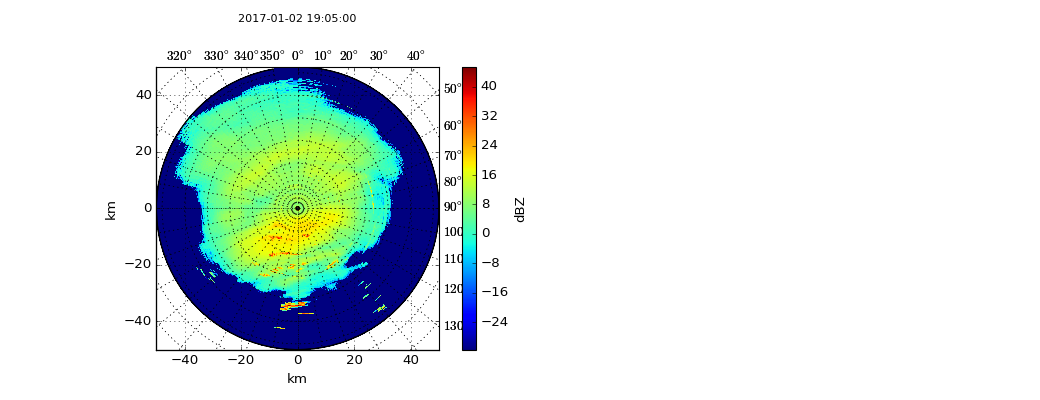

In [34]:
fig = plt.figure(figsize=(13,5))
subplot = 121

#fraction=0.1
#shrink=1
#pad=0.09
#fontsize=12

Show.polar_plot(data, r, az, title, units, subplot)

In [25]:
break

SyntaxError: 'break' outside loop (<ipython-input-25-b20fcc2397e7>, line 1)

# Save results

out path

In [ ]:
raw_data_root_path = azi_data_root_path
print raw_data_root_path

make directories for results

In [ ]:
io_path_res, io_path_res_lev1, io_path_res_lev2 = Save.make_dir(raw_data_root_path, year, month)
print io_path_res
print io_path_res_lev1
print io_path_res_lev2

sanity report

In [ ]:
file_scheck = 'Log_sanity_checks_'+year+'-'+month
filename_scheck = io_path_res_lev2+'\\'+file_scheck+'.npz'
filename_scheck_txt = io_path_res_lev2+'\\'+file_scheck+'.txt'

In [ ]:
c = []
Save.scan_errors(a, b, c, thr_empty, file_scheck, filename_scheck, filename_scheck_txt, io_path_res_lev2)

adjust azimuth report

In [ ]:
file_pos = 'Difference to Ref-scan vs time '+year+'-'+month
filename_pos = io_path_res_lev2+'\\'+file_pos+'.npz'
filename_pos_png = io_path_res_lev2+'\\'+file_pos+'.png'

In [ ]:
def positions_azimuth(thetas_list_aligned, file_pos, filename_pos, filename_pos_png, io_path_res_lev2):
    time = []
    Position0 = []
    Position1 = []
    Position2 = []
    Position3 = []
    Position4 = []
    corr_list = []
    
    dir_results_files = os.listdir(io_path_res_lev2)
    
    if (file_pos+'.npz') in dir_results_files:    ##check if file "Log_sanity_checks" allready exists
        print "File existing:", str(file_scheck)
        pos_data1=np.load(filename_pos)
        time=pos_data1['time']
        Position0=pos_data1['Position0']
        Position1=pos_data1['Position1']
        Position2=pos_data1['Position2']
        Position3=pos_data1['Position3']
        Position4=pos_data1['Position4']
        corr_list=pos_data1['corr_list']
        
        else:
        #init_s_check_file(filename_scheck, Version_IFU, thr2, max_delay)
        print "File new:", str(file_pos)
    

    time = np.hstack((time,time_file))
    Position0 = np.hstack((Position0, thetas[0]))
    Position1 = np.hstack((Position1, thetas[1]))
    Position2 = np.hstack((Position2, thetas[2]))
    Position3 = np.hstack((Position3, thetas[3]))
    Position4 = np.hstack((Position4, thetas[4]))
    corr_list = np.hstack((corr_list, corr_azi))
    
    ## save positions of the becons of a month
    np.savez_compressed(filename_pos, time=time, Position0=Position0, Position1=Position1, Position2=Position2, Position3=Position3, Position4=Position4, corr_list=corr_list)
    #print "filename_pos:", filename_pos
    time_plot(time, Position0, Position1, Position2, Position3, Position4, corr_list, delta_spl, month, filename_pos+'.png')

In [ ]:
def time_plot(time, Position0, Position1, Position2, Position3, Position4, corr_list, delta_spl, month, path_Results):
    #### plotting positions vs. time
    
    ### Vord.Hoernle (Bad Kohlgrub), range 103
    ### Hoher Trauchberg/Hoher Bleick (Unterammergauer), range 127
    ### Klammspitz (Ammergauer north), range 165
    ### Krottenkopf (Estergbirge), range 233
    ### Kreutzspitze + Kuchelberg (Ammergauer south), range 263
    ### Zugspitze, range 346
    
    delta=delta_spl
    #file_path=path_Results
    x=np.arange(0,1,1)
    #yr = int(str(time[1])[0:4])
    #mo = int(str(time[1])[4:6])
    #RefDate = date2dec(calendar='proleptic_gregorian', yr = 2013, mo = 1, dy = 1, hr = 0,  mi = 0)
    #RefDate = date2dec(calendar='proleptic_gregorian', yr = yr, mo = mo, dy = 1, hr = 0,  mi = 0)
    for t in time[1:]:
        #t=int(t)
        #print(time[155:205])
        ts=int(str(t)[0:12])
        #print (ts)
        #yr = int(str(t)[0:4])
        #mo = int(str(t)[4:6])
        #dy = int(str(t)[6:8])
        #hr = int(str(t)[8:10])
        #mi = int(str(t)[10:12])
        #print(yr, mo, dy, hr, mi)
        #tx=date2dec(calendar='proleptic_gregorian', yr=yr, mo = mo, dy = dy, hr = hr, mi = mi ) - RefDate
        tx = datetime.datetime.strptime(str(int(ts)),'%Y%m%d%H%M')
        x=np.hstack((x,tx))
        #print(x)
        
    x=x[1:]
    #print(x)
    t=time[1:2]  ## first timestamp
    #t=int(t)
    #print('t=',t)
    #yr = str(t)[1:5]
    #mo = str(t)[5:7]
    #print('yr=',yr)
    #print('mo=',mo)
    #day1=yr+mo+'010000'
    day1=str(int(str(t)[1:7]))+'010000'
    #day1=str(int(str(t)[0:6]))+'010000'
    day1 = datetime.datetime.strptime(str(int(day1)),'%Y%m%d%H%M')
    #print('day1=',day1)
    day_last=str(int(str(t)[1:7])+1)+'010000'
    #day_last=str(int(str(t)[0:6])+1)+'010000'
    day_last = datetime.datetime.strptime(str(int(day_last)),'%Y%m%d%H%M')

    y0=Position0[1:]
    #print('y0=',y0[:])
    y1=Position1[1:]
    #print('y1=',y1[:5])
    y2=Position2[1:]
    #print('y2=',y2[:5])
    y3=Position3[1:]
    #print('y3=',y3[:5])
    y4=Position4[1:]
    y5=corr_list[1:]
    #print('y3=',y3[:5])
    
    #fig, (ax, axes, axe, axes0, axes1, axes2, axes3, axes4) = pl.subplots(nrows=8, ncols=1,figsize=(20,20))
    #fig, (axes0, axes1, axes2, axes3) = pl.subplots(nrows=4, ncols=1,figsize=(20,20))
    fig, (axes0, axes1, axes2, axes3, axes4, axes5) = pl.subplots(nrows=6, ncols=1,figsize=(20,20))
    #fig, (ax, axes, axes0, axes1) = pl.subplots(nrows=4, ncols=1,figsize=(20,10))
    #fig, axes = pl.subplots(figsize=(20,3))
    
    axes0.plot(x, y0, 'r', linestyle='None', marker='.')
    axes0.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes0.set_ylabel('Diff. / slice', fontsize=15)
    axes0.grid()
    axes0.set_xlim([day1,day_last])
    axes0.set_title('Vord.Hoernle (Bad Kohlgrub), range='+str(ranges[0])+',  +/-'+str(delta)+' slices, linear,'+' spline '+str(k)+'-degre', fontsize=20)
    
    axes1.plot(x, y4, 'r', linestyle='None', marker='.')
    axes1.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes1.set_ylabel('Diff. / slice', fontsize=15)
    axes1.grid()
    axes1.set_xlim([day1,day_last])
    axes1.set_title('Hoher Trauchberg/Hoher Bleick (Unterammergauer), range='+str(ranges[4])+',  +/-'+str(delta)+' slices, linear,'+' spline '+str(k)+'-degre', fontsize=20)
    
    
    axes2.plot(x, y1, 'r', linestyle='None', marker='.')
    axes2.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes2.set_ylabel('Diff. / slice', fontsize=15)
    axes2.grid()
    axes2.set_xlim([day1,day_last])
    axes2.set_title('Klammspitz (Ammergauer north), range='+str(ranges[1])+',  +/-'+str(delta)+' slices, linear,'+' spline '+str(k)+'-degre', fontsize=20)
    
    axes3.plot(x, y2, 'r', linestyle='None', marker='.')
    axes3.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes3.set_ylabel('Diff. / slice', fontsize=15)
    axes3.grid()
    axes3.set_xlim([day1,day_last])
    axes3.set_title('Kreutzspitze + Kuchelberg (Ammergauer south), range='+str(ranges[2])+',  +/-'+str(delta)+' slices, linear,'+' spline '+str(k)+'-degre', fontsize=20)
    
    axes4.plot(x, y3, 'r', linestyle='None', marker='.')
    axes4.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes4.set_ylabel('Diff. / slice', fontsize=15)
    axes4.grid()
    axes4.set_xlim([day1,day_last])
    axes4.set_title('Zugspitze, range='+str(ranges[3])+',  +/-'+str(delta)+' slices, linear,'+' spline '+str(k)+'-degre', fontsize=20)
    
    axes5.plot(x, y5, 'b', linestyle='None', marker='.')
    axes5.set_xlabel(month+'  (time/decimal)', fontsize=15)
    axes5.set_ylabel('azimuth', fontsize=15)
    axes5.grid()
    axes5.set_xlim([day1,day_last])
    axes5.set_title('azimuth correction', fontsize=20)
    
    fig.tight_layout()
    #fig.savefig(path_Results+'\\'+'Difference to Ref-scan vs time '+month+' '+str(delta)+'-slices'+' '+str(k)+'-deg'+'.png')
    fig.savefig(path_Results)